# Pool Ball Position Estimator

So a few years ago, i tried to read a popular account about Baye's Rule: [*The Theory That Would Not Die*](https://www.amazon.com/Theory-That-Would-Not-Die-ebook/dp/B0050QB3EQ/ref=tmm_kin_swatch_0?_encoding=UTF8&qid=&sr=).
Like most books of its type, it tried real hard not to use any equations, resulting in a mess of handwaving interspersed with historical details.
I didn't get much out of it and, apparently, [I'm not the only one](http://www.popularscience.co.uk/reviews/rev654.htm).

But it had one introductory example that interested me: a person stands with his back to a pool table with a single ball on it, and he can determine the position of the ball knowing nothing more than whether other randomly rolled balls stop to the left or right of the it. I could see how to do that from a [frequentist viewpoint](https://en.wikipedia.org/wiki/Frequentist_inference) by looking at the proportion of the balls ending up to the left and right. But how certain was the estimate for a given number of left/right trials? I guess I could figure that out, but it would probably involve probability distributions and integration, so **NO**.

Then a few months ago, I saw a video by Allen Downey about Bayesian statistics (maybe it was [this one](https://www.youtube.com/watch?v=R6d-AbkhBQ8)) and I got enough from that to "solve" the pool ball problem.
(I say "solve" because I can compute the probabilities but I don't have a closed-form, analytical expression for them.)

To set up the problem, you always start with some definitions. Otherwise you'll end up with more hand waving.

* $B_L$: The left bound of the allowable interval for the pool balls (usually zero).
* $B_R$: The right bound of the allowable interval for the pool balls.
* $x$: The actual (but unknown) position of the first ball placed on the pool table $B_L \le x \le B_R$.

Then there are two possible events depending upon whether a randomly-rolled pool ball ends up to the left or right of the first ball.

* $L$: An event in which a randomly-rolled ball comes to rest to the left of the first pool ball.
* $R$: An event in which a randomly-rolled ball comes to rest to the right of the first pool ball.

Each event has a probability that it will occur: $P(L)$ and $P(R)$. In this example these are easy to compute,
but we'll see later we really don't need to.

Next there is the *prior probability* which is merely a guess of where the first pool ball is:
* $P(i)$: The probability the first pool ball is at position $i$ where $B_L \le i \le B_R$.

Then there is the *posterior probability* which is an update of the prior based on whether an $L$ or $R$ event occurred.
The posterior should start to "hump up" around $x$ as more and more events occur.
* $P(i|L)$: The probability the first pool ball is at position $i$ given that an $L$ event occurred.
* $P(i|R)$: The probability the first pool ball is at position $i$ given that an $R$ event occurred.

The posterior is what we want because it shows where the first ball is located,
but it's not obvious how to compute it. If it was, we wouldn't need Baye's rule:

$$P(i|L)P(L) = P(L|i)P(i)$$

$$P(i|L) = \frac{P(L|i)P(i)}{P(L)}$$

So we can find $P(i|L)$ and $P(i|R)$ if we just have the opposite conditional probabilities $P(L|i)$ and $P(R|i)$.
Luckily, those are easy to compute in this example:
* $P(L|i)$: The probability an $L$ event will occur if the first pool ball is at position $i$. Assuming the random rolling procedure follows a uniform distribution in the range $[B_L, B_R]$, then $P(L|i) = \frac{i - B_L}{B_R - B_L}$. So as the first ball is placed further to the right (i.e., $i$ gets closer to $B_R$), then the probability a randomly rolled ball ends up to the left gets higher.
* $P(R|i)$: The probability an $R$ event will occur if the first pool ball is at position $i$. Obviously, $P(R|i) = 1 - P(L|i)$ because the rolled ball has to end up *somewhere*.

Now the procedure for computing the position is:

1. Pick values for $B_L$, $B_R$ and $x$.
1. Select $N$ points between $B_L$ and $B_R$. Each point will have a position $i$ and a corresponding probability $P(i)$.
1. Since we have no idea where the first ball is located, set the prior probability at each point to $1/N$.
1. Randomly roll a ball by generating a uniformly-distributed random number between $B_L$ and $B_R$. This will generate an $L$ or $R$ event depending upon whether the random number is less-than or greater-than $x$.
1. At each point, generate the posterior probability as follows:
    $$P(i|L) = P(L|i)P(i) = \frac{i - B_L}{B_R - B_L} \frac{1}{N}$$ for event $L$.
    $$P(i|R) = P(R|i)P(i) = \frac{B_R - i}{B_R - B_L} \frac{1}{N}$$ for event $R$.


In [8]:
from random import uniform
import numpy as np
from numpy.linalg import norm

class PoolBallPositionEstimator:
    def __init__(self, ball_pos, left_bound=0, right_bound=100, precision=101):
        self.ball_pos = ball_pos
        self.left_bound = left_bound
        self.right_bound = right_bound
        self.estimates = np.zeros(precision, dtype=[('pos','f4'),('prob','f4')])
        self.estimates['prob'] = np.full(precision, 1.0/precision)
        self.estimates['pos'] = np.linspace(left_bound, right_bound, precision)
        
    def roll_new_ball(self):
        return uniform(self.left_bound, self.right_bound)
        
    def update(self,roll):
        interval = self.right_bound - self.left_bound
        if self.ball_pos < roll:
            self.estimates['prob'] *= (self.right_bound - self.estimates['pos']) / interval
        else:
            self.estimates['prob'] *= self.estimates['pos'] / interval
        self.estimates['prob'] /= norm(self.estimates['prob'], ord=1)


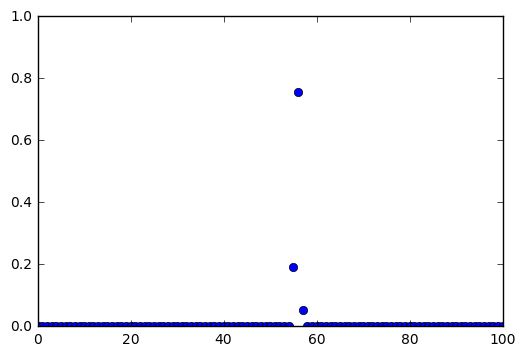

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML

pbpe = PoolBallPositionEstimator(ball_pos=55, precision=101)

fig, ax = plt.subplots()
ax.set_ylim([0.0,1.0])

line, = ax.plot(pbpe.estimates['pos'], pbpe.estimates['prob'], 'bo')

def animate(i):
    for _ in range(10):
        pbpe.update(pbpe.roll_new_ball())
    line.set_ydata(pbpe.estimates['prob'])  # update the data
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(pbpe.estimates['prob'])  # update the data
    return line,

anim = animation.FuncAnimation(fig, animate, range(1000), init_func=init,
                              interval=10, blit=True)
rc('animation',html='html5')
HTML(anim.to_html5_video())
anim